In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import numpy as np
from scipy.signal import argrelmin, argrelmax
from matplotlib import pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

Using TensorFlow backend.


In [2]:
#Check Versions
print(tf.__version__) #1.15.0
print(keras.__version__) #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{(1-f(x_{T,i},\theta'))}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the first Gaussian Notebook.

We will now parametrize our network by giving it a $\mu$ value in addition to $X_i\sim\mathcal{N}(\mu, 1)$.

First we uniformly sample $\mu$ values in some range

In [3]:
n_data_points = 5*10**6
sigma_min = 0.5
sigma_max = 4.5
sigma_values = np.random.uniform(sigma_min, sigma_max, n_data_points)

We then sample from normal distributions with this $\mu$ value

In [4]:
X0 = [(np.random.normal(0, 1), sigma) for sigma in sigma_values] # Note the zero in normal(0, 1) 
X1 = [(np.random.normal(0, sigma), sigma) for sigma in sigma_values]

Please note that the samples in X0 are not paired with $\sigma=0$ as this would make the task trivial. 

Instead it is paired with the $\sigma$ values uniformly sampled in the specified range [sigma_min, sigma_max].

For every value of $\sigma$ in mu_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(0, \sigma)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\sigma$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(0, \sigma)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

In [5]:
Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Build Model

In [6]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics =['accuracy'])

## Train DCTR model

In [ ]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
          epochs=200, 
          batch_size = 10000,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8000000 samples, validate on 2000000 samples
Epoch 1/200





4450000/8000000 [===============>..............] - ETA: 6s - loss: 0.5650 - acc: 0.6804

# Saving Model

In [ ]:
'''
model_json = dctr_model.to_json()
with open("1d_gaussian_dctr_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dctr_model.save_weights("1d_gaussian_dctr_model.h5")
print("Saved model to disk")
'''

# Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [ ]:
theta0_param = 1

def reweight(d): #from NN (DCTR)
    f = dctr_model(d)
    weights = (f[:,1])/(f[:,0])
    weights = K.expand_dims(weights, axis = 1)
    return weights


def analytical_reweight(d): #from analytical formula for normal distributions
    events = d[:,0]
    param = d[:,1]
    weights = (1/param)*K.exp(-0.5*(((events)/param)**2-((events))**2))
    weights = K.expand_dims(weights, axis = 1)
    return weights

## Validate DCTR for any $\mu$ and $\sigma$

In [ ]:
sigma1 = 2
assert sigma1>=sigma_min and sigma1<=sigma_max # choose mu1 in valid range
X0_val = np.random.normal(0, 1, n_data_points)
X1_val = np.random.normal(0, sigma1, n_data_points)

In [ ]:
X_input = np.array([(x, sigma1) for x in X0_val])

In [ ]:
weights = reweight(tf.convert_to_tensor(X_input, dtype = tf.float32))
analytical_weights = analytical_reweight(tf.convert_to_tensor(X_input, dtype = tf.float32))
weights = K.eval(weights)
analytical_weights = K.eval(analytical_weights)

In [ ]:
bins = np.linspace(-8,8,31)
plt.hist(X0_val, bins = bins, alpha = 0.5, label = r'$\sigma=1$')
plt.hist(X0_val, bins = bins, label = r'$\sigma=1$ NN wgt.',
         weights=weights, histtype='step', color='k')
plt.hist(X0_val, bins = bins, label = r'$\sigma=1$ analytical wgt.',
         weights=analytical_weights, histtype='step', linestyle = '--',color='k')
plt.hist(X1_val, bins = bins, alpha = 0.5, label = r'$\sigma={}$'.format(sigma1))
plt.legend()
plt.title("Truth Level: Reweighting")
plt.show()

# Alternative Fit

# Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

In [ ]:
N = 10**6
theta0_param = 1 #this is the simulation ... N.B. this notation is reversed from above!
theta1_param = 1.5 #this is the data (the target)

theta0 = np.random.normal(0,theta0_param,N)
theta1 = np.random.normal(0,theta1_param,N)
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0,theta1])
yvals = np.concatenate([labels0,labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals, yvals, test_size=0)

# Fitting Model

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

# Loading Model

In [ ]:
# load json and create model
'''
json_file = open('1d_gaussian_dctr_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dctr_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
dctr_model.load_weights("1d_gaussian_dctr_model.h5")
print("Loaded model from disk")
'''


In [ ]:
# Change to True for analytical_reweight

reweight_analytically = False

# Creating Model

In [ ]:
myinputs = Input(shape=(1,), dtype = tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
model.summary()

earlystopping = EarlyStopping(monitor='loss',
                              patience = 3, 
                              min_delta = 0.00005,
                              restore_best_weights=True)

def my_loss_wrapper(inputs,val=0.):
    x  = inputs
    x = K.gather(x, np.arange(1000))

    theta = 0. #starting value
    theta_prime = val
    
    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape = x.shape)*theta_prime
    #combining and reshaping into correct format:
    data = K.concatenate((x, concat_input_and_params), axis=-1)
    
    if reweight_analytically == False: #NN reweight
        w = reweight(data)
    else: # analytical reweight
        w = analytical_reweight(events = x,  
                                sigma1 = theta_prime)
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss

# Training Model

In [ ]:
thetas = np.linspace(0.5,4.5,33)
lvals = []


for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    model.fit(np.array(X_train), y_train,
              epochs=100, batch_size=1000,
              validation_data=(np.array(X_test), y_test),
              verbose=1, callbacks = [earlystopping])
    lvals+=[np.min(model.history.history['loss'])]
    print
    pass
print(lvals)

In [ ]:
plt.plot(thetas,lvals)
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(np.std(theta1), ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.legend()
plt.show()

We've shown for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

# Building and Training Fitting Model

In [ ]:
print_weights = LambdaCallback(on_epoch_end=lambda batch,
                               logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 1.
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(monitor='loss',
                              patience = 3, 
                              #min_delta = 0.00005,
                              restore_best_weights=True)

In [ ]:
myinputs_fit = Input(shape=(1,))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape = list(),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False
index_refine = np.array([0])
batch_size = 2*N
lr = 5e-1 #smaller learning rate yields better precision
iterations = 100 #but requires more epochs to train
optimizer = keras.optimizers.Adam(lr=lr)
index_switch = 0

def my_loss_wrapper_fit(inputs,mysign = 1):
    x  = inputs
    
    theta = 0. #starting value
    #Getting theta_prime:
    if train_theta == False:
        x = K.gather(x, np.arange(1000))
        theta_prime = model_fit.layers[-1].get_weights() #when not training theta, fetch as np array 
    else:
        x = K.gather(x, np.arange(batch_size))
        theta_prime = model_fit.trainable_weights[-1] #when trainingn theta, fetch as tf.Variable
        
    #creating tensor with same length as inputs, with theta_prime in every entry
    theta0_stack = K.ones_like(x,dtype=tf.float32)*theta0 
    concat_input_and_params = K.ones(shape = (x.shape), dtype=tf.float32)*theta_prime
    
    #combining and reshaping into correct format:
    data = K.concatenate((x, concat_input_and_params), axis=-1)
   
    if reweight_analytically == False: #NN reweight
        w = reweight(data)
    else: # analytical reweight
        w = analytical_reweight(data)
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        #t_loss = mysign*(y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -mysign*((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        
        return K.mean(t_loss)
    return my_loss

In [22]:
for iteration in range(iterations):    
    print("Iteration: ",iteration )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss=my_loss_wrapper_fit(myinputs_fit,1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train), y_train, epochs=50, batch_size=1000,validation_data=(np.array(X_test), y_test),verbose=1, callbacks = [earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer=optimizer, loss=my_loss_wrapper_fit(myinputs_fit,-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train), y_train, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=callbacks)
    
        
        # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10
    
    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]
    
    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
            
    extrema = np.concatenate((argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]
    '''
    print("index_refine", index_refine)
    print("extrema", extrema)
    '''
    
    if (len(extrema) == 0): # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema) >= 6): #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print("Refining learning rate")
        optimizer.lr = optimizer.lr/10.
    pass
    

2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7000 - acc: 0.4391
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.7000 - acc: 0.4226
. theta fit =  1.531681
Iteration:  47
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 20s 10us/step - loss: 0.7002 - acc: 0.4404
Epoch 2/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7001 - acc: 0.4326
Epoch 3/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7001 - acc: 0.4343
Epoch 4/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7000 - acc: 0.4337
Epoch 5/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7000 - acc: 0.4340
Epoch 6/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7000 - acc: 0.4370
Epoch 7/50
200000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7000 - acc: 0.4355
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.6999 - acc: 0.4269
. theta fit =  1.5316471
Iteration:  52
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 21s 11us/step - loss: 0.7002 - acc: 0.4315
Epoch 2/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7000 - acc: 0.4359
Epoch 3/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7001 - acc: 0.4337
Epoch 4/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7000 - acc: 0.4350
Epoch 5/50
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7000 - acc: 0.4363
Epoch 6/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7000 - acc: 0.4308
Epoch 7/50
20000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 11s 6us/step - loss: 0.6999 - acc: 0.4334
Epoch 8/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7001 - acc: 0.4364
Epoch 9/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4393
Epoch 10/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4269
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 15s 7us/step - loss: -0.7001 - acc: 0.4157
. theta fit =  1.5317562
Iteration:  55
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 21s 11us/step - loss: 0.7002 - acc: 0.4385
Epoch 2/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7001 - acc: 0.4329
Epoch 3/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7001 - acc: 0.4322
Epoch 4/50
2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7001 - acc: 0.4380
Epoch 9/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4348
Epoch 10/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4349
Epoch 11/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4330
Epoch 12/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7000 - acc: 0.4300
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 15s 7us/step - loss: -0.7000 - acc: 0.4380
. theta fit =  1.5318294
Iteration:  57
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 22s 11us/step - loss: 0.7003 - acc: 0.4352
Epoch 2/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4351
Epoch 3/50
20

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4309
Epoch 3/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4355
Epoch 4/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7001 - acc: 0.4248
Epoch 5/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4355
Epoch 6/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7000 - acc: 0.4360
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 15s 8us/step - loss: -0.7000 - acc: 0.4229
. theta fit =  1.5319046
Iteration:  61
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 23s 11us/step - loss: 0.7001 - acc: 0.4267
Epoch 2/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4370
Epoch 3/50
20000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 24s 12us/step - loss: 0.7004 - acc: 0.4297
Epoch 2/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7001 - acc: 0.4390
Epoch 3/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4284
Epoch 4/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4365
Epoch 5/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7001 - acc: 0.4338
Epoch 6/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4339
Epoch 7/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7000 - acc: 0.4283
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 16s 8us/step - loss: -0.7000 - acc: 0.4314
. theta fit =  1.531955
Iteration:  65
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
200000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4335
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 16s 8us/step - loss: -0.7001 - acc: 0.4160
. theta fit =  1.5319551
Iteration:  67
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 24s 12us/step - loss: 0.7004 - acc: 0.4371
Epoch 2/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7001 - acc: 0.4340
Epoch 3/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4302
Epoch 4/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4318
Epoch 5/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.6999 - acc: 0.4325
Epoch 6/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7001 - acc: 0.4317
Epoch 7/50
20000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4325
Epoch 9/50
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7000 - acc: 0.4347
Epoch 10/50
2000000/2000000 [==============================] - ETA: 0s - loss: 0.7000 - acc: 0.434 - 12s 6us/step - loss: 0.7000 - acc: 0.4349
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 16s 8us/step - loss: -0.6999 - acc: 0.4209
. theta fit =  1.5319633
Iteration:  71
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 23s 12us/step - loss: 0.7002 - acc: 0.4360
Epoch 2/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4353
Epoch 3/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4279
Epoch 4/50
2000000/2000000 [==============================] - 12s 6us/step - loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7001 - acc: 0.4298
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 16s 8us/step - loss: -0.6999 - acc: 0.4616
. theta fit =  1.5319633
Refining learning rate
Iteration:  73
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 24s 12us/step - loss: 0.7000 - acc: 0.4359
Epoch 2/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4285
Epoch 3/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4371
Epoch 4/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4338
Epoch 5/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4337
Epoch 6/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 2/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4328
Epoch 3/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7001 - acc: 0.4352
Epoch 4/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4363
Epoch 5/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7001 - acc: 0.4343
Epoch 6/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4328
Epoch 7/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4392
Epoch 8/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4368
Epoch 9/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4335
Epoch 10/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4370
Training theta
Train on 2000000 samples, validate on 0 samples


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7000 - acc: 0.4345
Epoch 7/50
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7000 - acc: 0.4338
Epoch 8/50
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7000 - acc: 0.4294
Epoch 9/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.6999 - acc: 0.4320
Epoch 10/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7001 - acc: 0.4394
Epoch 11/50
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7000 - acc: 0.4317
Epoch 12/50
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7000 - acc: 0.4316
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 17s 9us/step - loss: -0.7000 - acc: 0.4307
. theta fit =  1.5319642
Iteration:  79
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
200

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7000 - acc: 0.4345
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 18s 9us/step - loss: -0.6999 - acc: 0.4187
. theta fit =  1.5319651
Iteration:  81
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 26s 13us/step - loss: 0.7004 - acc: 0.4381
Epoch 2/50
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7000 - acc: 0.4375
Epoch 3/50
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7000 - acc: 0.4310
Epoch 4/50
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7000 - acc: 0.4309
Epoch 5/50
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7000 - acc: 0.4371
Epoch 6/50
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7000 - acc: 0.4364
Epoch 7/50
20000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7000 - acc: 0.4350
Epoch 5/50
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7001 - acc: 0.4354
Epoch 6/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7000 - acc: 0.4295
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 18s 9us/step - loss: -0.6999 - acc: 0.4612
. theta fit =  1.5319666
Iteration:  84
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 26s 13us/step - loss: 0.7001 - acc: 0.4371
Epoch 2/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6999 - acc: 0.4300
Epoch 3/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7000 - acc: 0.4377
Epoch 4/50
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7000 - acc: 0.4305
Epoch 5/50
20000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7001 - acc: 0.4357
Epoch 3/50
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.6999 - acc: 0.4339
Epoch 4/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7001 - acc: 0.4368
Epoch 5/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7000 - acc: 0.4358
Epoch 6/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7000 - acc: 0.4342
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 18s 9us/step - loss: -0.7002 - acc: 0.4166
. theta fit =  1.5319675
Iteration:  88
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 27s 13us/step - loss: 0.7005 - acc: 0.4380
Epoch 2/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7000 - acc: 0.4334
Epoch 3/50
20000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7000 - acc: 0.4346
Epoch 8/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7000 - acc: 0.4308
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 19s 10us/step - loss: -0.6999 - acc: 0.4254
. theta fit =  1.5319675
Iteration:  90
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 27s 14us/step - loss: 0.7001 - acc: 0.4374
Epoch 2/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7000 - acc: 0.4322
Epoch 3/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7000 - acc: 0.4322
Epoch 4/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7000 - acc: 0.4334
Epoch 5/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7000 - acc: 0.4339
Epoch 6/50
2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6999 - acc: 0.4358
Epoch 5/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7001 - acc: 0.4395
Epoch 6/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7001 - acc: 0.4321
Epoch 7/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4351
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 19s 10us/step - loss: -0.7001 - acc: 0.4170
. theta fit =  1.5319675
Iteration:  93
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 28s 14us/step - loss: 0.7004 - acc: 0.4442
Epoch 2/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4296
Epoch 3/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4369
Epoch 4/50
2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7001 - acc: 0.4356
Epoch 7/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4284
Epoch 8/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4334
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 19s 10us/step - loss: -0.7000 - acc: 0.4494
. theta fit =  1.5319675
Iteration:  96
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 29s 14us/step - loss: 0.7001 - acc: 0.4329
Epoch 2/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4316
Epoch 3/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.7000 - acc: 0.4341
Epoch 4/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6999 - acc: 0.4306
Epoch 5/50
2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4314
Epoch 10/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4328
Epoch 11/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4334
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 19s 10us/step - loss: -0.7000 - acc: 0.4174
. theta fit =  1.5319675
Iteration:  98
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 29s 15us/step - loss: 0.7004 - acc: 0.4390
Epoch 2/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4374
Epoch 3/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4283
Epoch 4/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4344
Epoch 5/50
20

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4345
Epoch 10/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7000 - acc: 0.4320
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 20s 10us/step - loss: -0.6999 - acc: 0.4235
. theta fit =  1.5319675


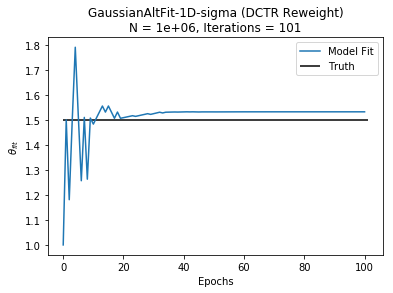

In [23]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(np.std(theta1), 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("GaussianAltFit-1D-sigma (DCTR Reweight)\nN = {:.0e}, Iterations = {:.0f}".format(N, len(fit_vals)))
plt.savefig("GaussianAltFit1D-sigma (DCTR Reweight)\nN = {:.0e}, Iterations = {:.0f}.png".format(N, len(fit_vals)))
plt.show()


In [24]:
reweight_analytically = True

In [25]:
print_weights = LambdaCallback(on_epoch_end=lambda batch,
                               logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 1.
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(monitor='loss',
                              patience = 3, 
                              #min_delta = 0.00005,
                              restore_best_weights=True)

In [26]:
myinputs_fit = Input(shape=(1,))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape = list(),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False
index_refine = np.array([0])
batch_size = 2*N
lr = 5e-1 #smaller learning rate yields better precision
iterations = 100 #but requires more epochs to train
optimizer = keras.optimizers.Adam(lr=lr)
index_switch = 0

def my_loss_wrapper_fit(inputs,mysign = 1):
    x  = inputs
    
    theta = 0. #starting value
    #Getting theta_prime:
    if train_theta == False:
        x = K.gather(x, np.arange(1000))
        theta_prime = model_fit.layers[-1].get_weights() #when not training theta, fetch as np array 
    else:
        x = K.gather(x, np.arange(batch_size))
        theta_prime = model_fit.trainable_weights[-1] #when trainingn theta, fetch as tf.Variable
        
    #creating tensor with same length as inputs, with theta_prime in every entry
    theta0_stack = K.ones_like(x,dtype=tf.float32)*theta0 
    concat_input_and_params = K.ones(shape = (x.shape), dtype=tf.float32)*theta_prime
    
    #combining and reshaping into correct format:
    data = K.concatenate((x, concat_input_and_params), axis=-1)
   
    if reweight_analytically == False: #NN reweight
        w = reweight(data)
    else: # analytical reweight
        w = analytical_reweight(data)
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        #t_loss = mysign*(y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -mysign*((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_2 (Lambda)            (None, 1)                 1         
Total params: 16,898
Trainable params: 16,898
Non-trainable params: 0
_________________________________________________________________


In [27]:
for iteration in range(iterations):    
    print("Iteration: ",iteration )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss=my_loss_wrapper_fit(myinputs_fit,1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train), y_train, epochs=50, batch_size=1000,validation_data=(np.array(X_test), y_test),verbose=1, callbacks = [earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer=optimizer, loss=my_loss_wrapper_fit(myinputs_fit,-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train), y_train, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=callbacks)
    
        
        # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10
    
    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]
    
    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
            
    extrema = np.concatenate((argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]
    '''
    print("index_refine", index_refine)
    print("extrema", extrema)
    '''
    
    if (len(extrema) == 0): # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema) >= 6): #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print("Refining learning rate")
        optimizer.lr = optimizer.lr/10.
    pass
    

Iteration:  0
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 28s 14us/step - loss: 0.6595 - acc: 0.5912
Epoch 2/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6567 - acc: 0.5971
Epoch 3/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6565 - acc: 0.5969
Epoch 4/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6565 - acc: 0.5969
Epoch 5/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6565 - acc: 0.5969
Epoch 6/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6565 - acc: 0.5970
Epoch 7/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6565 - acc: 0.5970
Epoch 8/50
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6565 - acc: 0.5970
Epoch 9/50
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.6565 - ac

2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6893 - acc: 0.4119
Epoch 5/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6893 - acc: 0.4122
Epoch 6/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6892 - acc: 0.4128
Epoch 7/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6892 - acc: 0.4136
Epoch 8/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6891 - acc: 0.4137
Epoch 9/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6895 - acc: 0.4128
Epoch 10/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6894 - acc: 0.4128
Epoch 11/50
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6892 - acc: 0.4130
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 22s 11us/step - loss: -0.6895 - acc: 0.4192
. theta f

2000000/2000000 [==============================] - 34s 17us/step - loss: -0.6922 - acc: 0.4082
. theta fit =  1.5970978
Iteration:  13
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 33s 16us/step - loss: 0.6935 - acc: 0.4082
Epoch 2/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6931 - acc: 0.4082
Epoch 3/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6931 - acc: 0.4093
Epoch 4/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6931 - acc: 0.4095
Epoch 5/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6929 - acc: 0.4090
Epoch 6/50
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6929 - acc: 0.4101
Epoch 7/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6930 - acc: 0.4094
Epoch 8/50
2000000/2000000 [==============================] - 15s 7us/step - 

2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6937 - acc: 0.4961
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 23s 11us/step - loss: -0.6936 - acc: 0.5107
. theta fit =  1.5245818
Iteration:  20
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 33s 17us/step - loss: 0.6960 - acc: 0.4700
Epoch 2/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6940 - acc: 0.4419
Epoch 3/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6939 - acc: 0.4389
Epoch 4/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6936 - acc: 0.4407
Epoch 5/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6936 - acc: 0.4331
Epoch 6/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6939 - acc: 0.4341
Epoch 7/50
2000

2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6936 - acc: 0.4677
Epoch 8/50
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6938 - acc: 0.4705
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 23s 12us/step - loss: -0.6936 - acc: 0.4325
. theta fit =  1.5094329
Iteration:  27
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 45s 22us/step - loss: 0.6956 - acc: 0.4774
Epoch 2/50
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6942 - acc: 0.4608
Epoch 3/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6938 - acc: 0.4621
Epoch 4/50
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6936 - acc: 0.4685
Epoch 5/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6938 - acc: 0.4582
Epoch 6/50
2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6941 - acc: 0.4415
Epoch 3/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6939 - acc: 0.4457
Epoch 4/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6936 - acc: 0.4397
Epoch 5/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6938 - acc: 0.4354
Epoch 6/50
2000000/2000000 [==============================] - 30s 15us/step - loss: 0.6944 - acc: 0.4356
Epoch 7/50
2000000/2000000 [==============================] - 23s 11us/step - loss: 0.6940 - acc: 0.4380
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 24s 12us/step - loss: -0.6935 - acc: 0.4091
. theta fit =  1.5124031
Iteration:  36
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 38s 19us/step - loss: 0.6965 - acc: 0.4458
Epoch 2/50
20

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6943 - acc: 0.4345
Epoch 3/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6939 - acc: 0.4398
Epoch 4/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6936 - acc: 0.4374
Epoch 5/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6937 - acc: 0.4368
Epoch 6/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6937 - acc: 0.4363
Epoch 7/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6937 - acc: 0.4456
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 25s 13us/step - loss: -0.6935 - acc: 0.5003
. theta fit =  1.5150479
Iteration:  38
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 42s 21us/step - loss: 0.6967 - acc: 0.4489
Epoch 2/50
2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 38s 19us/step - loss: 0.6987 - acc: 0.4490
Epoch 2/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6945 - acc: 0.4389
Epoch 3/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6948 - acc: 0.4353
Epoch 4/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6935 - acc: 0.4369
Epoch 5/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6949 - acc: 0.4431
Epoch 6/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6939 - acc: 0.4399
Epoch 7/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6937 - acc: 0.4378
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 26s 13us/step - loss: -0.6936 - acc: 0.5003
. theta fit =  1.5150448
Iteration:  40
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 22s 11us/step - loss: 0.6946 - acc: 0.4484
Epoch 3/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6939 - acc: 0.4410
Epoch 4/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6936 - acc: 0.4430
Epoch 5/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6935 - acc: 0.4482
Epoch 6/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6939 - acc: 0.4400
Epoch 7/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6937 - acc: 0.4462
Epoch 8/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6938 - acc: 0.4404
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 26s 13us/step - loss: -0.6975 - acc: 0.4219
. theta fit =  1.5150487
Iteration:  42
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6942 - acc: 0.4412
Epoch 6/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6935 - acc: 0.4447
Epoch 7/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6943 - acc: 0.4551
Epoch 8/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6938 - acc: 0.4530
Epoch 9/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6936 - acc: 0.4391
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 26s 13us/step - loss: -0.6946 - acc: 0.4119
. theta fit =  1.5150522
Iteration:  44
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 43s 22us/step - loss: 0.6982 - acc: 0.4590
Epoch 2/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6946 - acc: 0.4431
Epoch 3/50
2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6936 - acc: 0.4411
Epoch 4/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6944 - acc: 0.4473
Epoch 5/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6936 - acc: 0.4418
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 26s 13us/step - loss: -0.6934 - acc: 0.4356
. theta fit =  1.5146842
Iteration:  46
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 39s 20us/step - loss: 0.6971 - acc: 0.4500
Epoch 2/50
2000000/2000000 [==============================] - 17s 9us/step - loss: 0.6942 - acc: 0.4438
Epoch 3/50
2000000/2000000 [==============================] - 17s 9us/step - loss: 0.6937 - acc: 0.4420
Epoch 4/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6936 - acc: 0.4369
Epoch 5/50
2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 17s 9us/step - loss: 0.6937 - acc: 0.4424
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 26s 13us/step - loss: -0.6934 - acc: 0.4110
. theta fit =  1.5146157
Iteration:  48
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 40s 20us/step - loss: 0.6964 - acc: 0.4508
Epoch 2/50
2000000/2000000 [==============================] - 17s 9us/step - loss: 0.6947 - acc: 0.4457
Epoch 3/50
2000000/2000000 [==============================] - 17s 9us/step - loss: 0.6942 - acc: 0.4469
Epoch 4/50
2000000/2000000 [==============================] - 17s 9us/step - loss: 0.6935 - acc: 0.4423
Epoch 5/50
2000000/2000000 [==============================] - 17s 9us/step - loss: 0.6939 - acc: 0.4433
Epoch 6/50
2000000/2000000 [==============================] - 18s 9us/step - loss: 0.6936 - acc: 0.4434
Epoch 7/50
2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6942 - acc: 0.4482
Epoch 6/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6936 - acc: 0.4470
Epoch 7/50
2000000/2000000 [==============================] - 22s 11us/step - loss: 0.6938 - acc: 0.4522
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 27s 14us/step - loss: -0.6934 - acc: 0.4194
. theta fit =  1.5145459
Iteration:  50
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 40s 20us/step - loss: 0.7001 - acc: 0.4593
Epoch 2/50
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6945 - acc: 0.4510
Epoch 3/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6938 - acc: 0.4487
Epoch 4/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6936 - acc: 0.4522
Epoch 5/50
200

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6938 - acc: 0.4532
Epoch 6/50
2000000/2000000 [==============================] - 23s 11us/step - loss: 0.6940 - acc: 0.4559
Epoch 7/50
2000000/2000000 [==============================] - 17s 9us/step - loss: 0.6939 - acc: 0.4573
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 26s 13us/step - loss: -0.6944 - acc: 0.4891
. theta fit =  1.5145463
Iteration:  52
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/50
2000000/2000000 [==============================] - 42s 21us/step - loss: 0.6998 - acc: 0.4703
Epoch 2/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6941 - acc: 0.4668
Epoch 3/50
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6934 - acc: 0.4595
Epoch 4/50
2000000/2000000 [==============================] - 17s 9us/step - loss: 0.6943 - acc: 0.4640
Epoch 5/50
200

2000000/2000000 [==============================] - 43s 22us/step - loss: 0.7000 - acc: 0.4496
Epoch 2/50
2000000/2000000 [==============================] - 18s 9us/step - loss: 0.6946 - acc: 0.4503
Epoch 3/50
2000000/2000000 [==============================] - 19s 9us/step - loss: 0.6937 - acc: 0.4568
Epoch 4/50
2000000/2000000 [==============================] - 19s 9us/step - loss: 0.6937 - acc: 0.4597
Epoch 5/50
2000000/2000000 [==============================] - 18s 9us/step - loss: 0.6936 - acc: 0.4488
Epoch 6/50
2000000/2000000 [==============================] - 17s 9us/step - loss: 0.6940 - acc: 0.4567
Epoch 7/50
2000000/2000000 [==============================] - 23s 11us/step - loss: 0.6963 - acc: 0.4571
Epoch 8/50
2000000/2000000 [==============================] - 18s 9us/step - loss: 0.6947 - acc: 0.4511
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 28s 14us/step - loss: -0.6940 - acc: 0.4326
. theta f

Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 29s 14us/step - loss: -0.6943 - acc: 0.4602
. theta fit =  1.5145531
Iteration:  66



KeyboardInterrupt: 

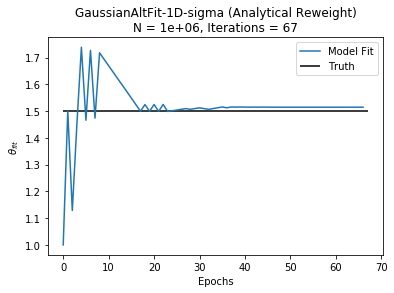

In [28]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(np.std(theta1), 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("GaussianAltFit-1D-sigma (Analytical Reweight)\nN = {:.0e}, Iterations = {:.0f}".format(N, len(fit_vals)))
plt.savefig("GaussianAltFit-1D-sigma (Analytical Reweight)\nN = {:.0e}, Iterations = {:.0f}.png".format(N, len(fit_vals)))
plt.show()

